Complete Python Notebook: Vanilla RNN from Scratch

This notebook demonstrates a basic implementation of a Vanilla Recurrent Neural Network (RNN)
from scratch using Python and NumPy, without using a class structure. It covers:
- Basic RNN forward and backward passes
- Training with and without dropout
- Training with different batch sizes
- Simulating pretraining and fine-tuning
- Visualization of hidden states

## Libraries

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Initialization ---

In [15]:
input_size = 5
hidden_size = 10
output_size = 3
learning_rate = 0.01

# Initialize weights with small random values

In [16]:
U = np.random.randn(hidden_size, input_size) * 0.01  # Input to hidden
W = np.random.randn(hidden_size, hidden_size) * 0.01 # Hidden to hidden
V = np.random.randn(output_size, hidden_size) * 0.01  # Hidden to output

# Initialize biases with zeros

In [17]:
b = np.zeros((hidden_size, 1))  # Hidden bias
c = np.zeros((output_size, 1))  # Output bias

# --- 2. Forward Pass ---

In [18]:
def softmax(x):
    """Applies the softmax activation function."""
    exp_x = np.exp(x - np.max(x)) # Subtract max for numerical stability
    return exp_x / np.sum(exp_x)

In [19]:
def forward(inputs, U, W, V, b, c):
    """
    Performs the forward pass of the RNN.
    """
    T = len(inputs)
    hidden_states = np.zeros((T + 1, hidden_size, 1))
    outputs = []
    hidden_states[0] = np.zeros((hidden_size, 1))
    for t in range(T):
        hidden_states[t+1] = np.tanh(np.dot(U, inputs[t]) + np.dot(W, hidden_states[t]) + b)
        output = softmax(np.dot(V, hidden_states[t+1]) + c)
        outputs.append(output)
    return outputs, hidden_states

In [20]:
def forward_with_dropout(inputs, U, W, V, b, c, dropout_rate=0.0):
    """
    Performs the forward pass of the RNN with optional dropout.
    """
    T = len(inputs)
    hidden_states = np.zeros((T + 1, hidden_size, 1))
    outputs = []
    dropout_masks = []
    hidden_states[0] = np.zeros((hidden_size, 1))
    for t in range(T):
        h_pre_activation = np.dot(U, inputs[t]) + np.dot(W, hidden_states[t]) + b
        hidden_states[t+1] = np.tanh(h_pre_activation)
        if dropout_rate > 0.0:
            dropout_mask = (np.random.rand(*hidden_states[t+1].shape) > dropout_rate) / (1 - dropout_rate)
            hidden_states[t+1] *= dropout_mask
            dropout_masks.append(dropout_mask)
        else:
            dropout_masks.append(np.ones_like(hidden_states[t+1]))
        output = softmax(np.dot(V, hidden_states[t+1]) + c)
        outputs.append(output)
    return outputs, hidden_states, dropout_masks

# --- 3. Backward Pass ---

In [21]:
def backward(inputs, outputs, hidden_states, targets, U, W, V, b, c):
    """
    Performs the backward pass of the RNN.
    """
    T = len(inputs)
    dU = np.zeros_like(U)
    dW = np.zeros_like(W)
    dV = np.zeros_like(V)
    db = np.zeros_like(b)
    dc = np.zeros_like(c)
    dh_next = np.zeros_like(hidden_states[0])
    for t in reversed(range(T)):
        target = np.zeros_like(outputs[t])
        target[targets[t]] = 1
        dy = outputs[t] - target
        dV += np.dot(dy, hidden_states[t+1].T)
        dc += dy
        dh = np.dot(V.T, dy) + dh_next
        dtanh = (1 - hidden_states[t+1] ** 2) * dh
        db += dtanh
        dU += np.dot(dtanh, inputs[t].T)
        dW += np.dot(dtanh, hidden_states[t].T)
        dh_next = np.dot(W.T, dtanh)
    return dU, dW, dV, db, dc

In [22]:
def backward_with_dropout(inputs, outputs, hidden_states, targets, U, W, V, b, c, dropout_masks):
    """
    Performs the backward pass of the RNN, considering dropout.
    """
    T = len(inputs)
    dU = np.zeros_like(U)
    dW = np.zeros_like(W)
    dV = np.zeros_like(V)
    db = np.zeros_like(b)
    dc = np.zeros_like(c)
    dh_next = np.zeros_like(hidden_states[0])
    for t in reversed(range(T)):
        target = np.zeros_like(outputs[t])
        target[targets[t]] = 1
        dy = outputs[t] - target
        dV += np.dot(dy, hidden_states[t+1].T)
        dc += dy
        dh = np.dot(V.T, dy) + dh_next
        dtanh = (1 - hidden_states[t+1] ** 2) * dh
        dtanh *= dropout_masks[t]
        db += dtanh
        dU += np.dot(dtanh, inputs[t].T)
        dW += np.dot(dtanh, hidden_states[t].T)
        dh_next = np.dot(W.T, dtanh)
    return dU, dW, dV, db, dc

# --- 4. Training Step ---

In [23]:
def train_step(inputs, targets, U, W, V, b, c, learning_rate):
    """
    Performs one step of training.
    """
    outputs, hidden_states = forward(inputs, U, W, V, b, c)
    dU, dW, dV, db, dc = backward(inputs, outputs, hidden_states, targets, U, W, V, b, c)
    U_new = U - learning_rate * dU
    W_new = W - learning_rate * dW
    V_new = V - learning_rate * dV
    b_new = b - learning_rate * db
    c_new = c - learning_rate * dc
    loss = -np.mean([np.log(outputs[t][targets[t], 0] + 1e-8) for t in range(len(targets))])
    return U_new, W_new, V_new, b_new, c_new, loss

In [24]:
def train_step_with_dropout(inputs, targets, U, W, V, b, c, learning_rate, dropout_rate):
    """
    Performs one training step with optional dropout.
    """
    outputs, hidden_states, dropout_masks = forward_with_dropout(inputs, U, W, V, b, c, dropout_rate)
    dU, dW, dV, db, dc = backward_with_dropout(inputs, outputs, hidden_states, targets, U, W, V, b, c, dropout_masks)
    U_new = U - learning_rate * dU
    W_new = W - learning_rate * dW
    V_new = V - learning_rate * dV
    b_new = b - learning_rate * db
    c_new = c - learning_rate * dc
    loss = -np.mean([np.log(outputs[t][targets[t], 0] + 1e-8) for t in range(len(targets))])
    return U_new, W_new, V_new, b_new, c_new, loss

In [25]:
def train_step_batch(batch_inputs, batch_targets, U, W, V, b, c, learning_rate):
    """
    Performs one training step with a batch of sequences.
    """
    batch_size = len(batch_inputs)
    total_loss = 0
    all_dU = np.zeros_like(U)
    all_dW = np.zeros_like(W)
    all_dV = np.zeros_like(V)
    all_db = np.zeros_like(b)
    all_dc = np.zeros_like(c)
    for i in range(batch_size):
        inputs = list(batch_inputs[i])
        targets = batch_targets[i]
        outputs, hidden_states = forward(inputs, U, W, V, b, c)
        dU, dW, dV, db, dc = backward(inputs, outputs, hidden_states, targets, U, W, V, b, c)
        all_dU += dU
        all_dW += dW
        all_dV += dV
        all_db += db
        all_dc += dc
        loss = -np.mean([np.log(outputs[t][targets[t], 0] + 1e-8) for t in range(len(targets))])
        total_loss += loss
    all_dU /= batch_size
    all_dW /= batch_size
    all_dV /= batch_size
    all_db /= batch_size
    all_dc /= batch_size
    U_new = U - learning_rate * all_dU
    W_new = W - learning_rate * all_dW
    V_new = V - learning_rate * all_dV
    b_new = b - learning_rate * all_db
    c_new = c - learning_rate * all_dc
    return U_new, W_new, V_new, b_new, c_new, total_loss / batch_size

# --- 5. Save and Load Model ---

In [26]:
def save_model(U, W, V, b, c, filename="pretrained_rnn.npz"):
    """Saves the RNN model weights and biases."""
    np.savez(filename, U=U, W=W, V=V, b=b, c=c)
    print(f"Model saved to {filename}")

In [27]:
def load_model(filename="pretrained_rnn.npz"):
    """Loads the RNN model weights and biases."""
    try:
        data = np.load(filename)
        return data['U'], data['W'], data['V'], data['b'], data['c']
    except FileNotFoundError:
        print(f"Error: Model file '{filename}' not found.")
        return None, None, None, None, None

# --- 6. Visualize Hidden States ---

In [28]:
def visualize_hidden_states(inputs, U, W, V, b, c):
    """Visualizes the hidden states of the RNN over time."""
    outputs, hidden_states = forward(inputs, U, W, V, b, c)
    T = len(inputs)
    plt.figure(figsize=(10, 6))
    for i in range(hidden_size):
        plt.plot(range(T + 1), hidden_states[:, i, 0], label=f'Hidden Unit {i+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Activation')
    plt.title('Hidden State Activations Over Time')
    plt.legend(ncol=3)
    plt.grid(True)
    plt.show()

# --- Example Usage ---

--- Training without Dropout ---
Epoch 10/50, Average Loss: 1.0965
Epoch 20/50, Average Loss: 1.0871
Epoch 30/50, Average Loss: 1.0448
Epoch 40/50, Average Loss: 0.9257
Epoch 50/50, Average Loss: 0.7755

--- Training with Dropout (rate = 0.5) ---
Epoch 10/50, Average Loss: 1.0969
Epoch 20/50, Average Loss: 1.0871
Epoch 30/50, Average Loss: 1.0193
Epoch 40/50, Average Loss: 0.9386
Epoch 50/50, Average Loss: 0.8695


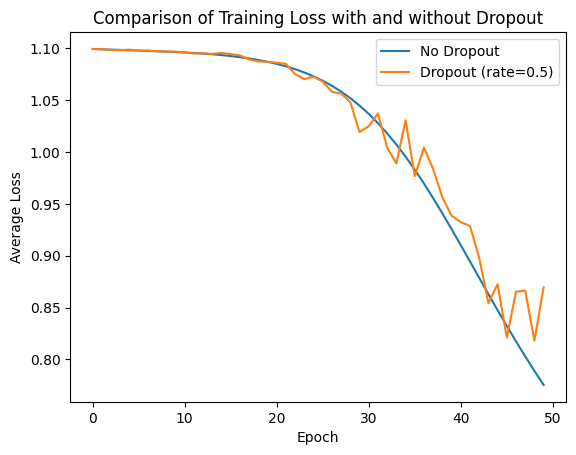


--- Training with Batch Size: 1 ---
Epoch 10/30, Average Loss: 1.0942
Epoch 20/30, Average Loss: 1.0916
Epoch 30/30, Average Loss: 1.0870

--- Training with Batch Size: 2 ---
Epoch 10/30, Average Loss: 1.0954
Epoch 20/30, Average Loss: 1.0935
Epoch 30/30, Average Loss: 1.0922

--- Training with Batch Size: 4 ---
Epoch 10/30, Average Loss: 1.0955
Epoch 20/30, Average Loss: 1.0933
Epoch 30/30, Average Loss: 1.0916


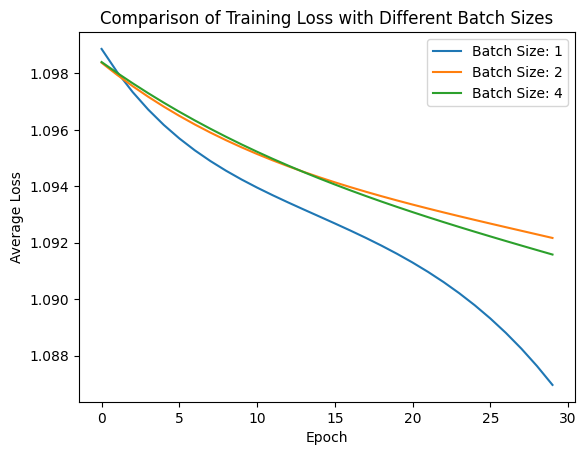


--- Pretraining the RNN ---
Pretrain Epoch 10/30, Average Loss: 1.0906
Pretrain Epoch 20/30, Average Loss: 1.0814
Pretrain Epoch 30/30, Average Loss: 1.0510
Model saved to pretrained_rnn.npz

--- Fine-tuning the Pretrained RNN ---
Finetune Epoch 10/20, Average Loss: 1.0475
Finetune Epoch 20/20, Average Loss: 1.0454


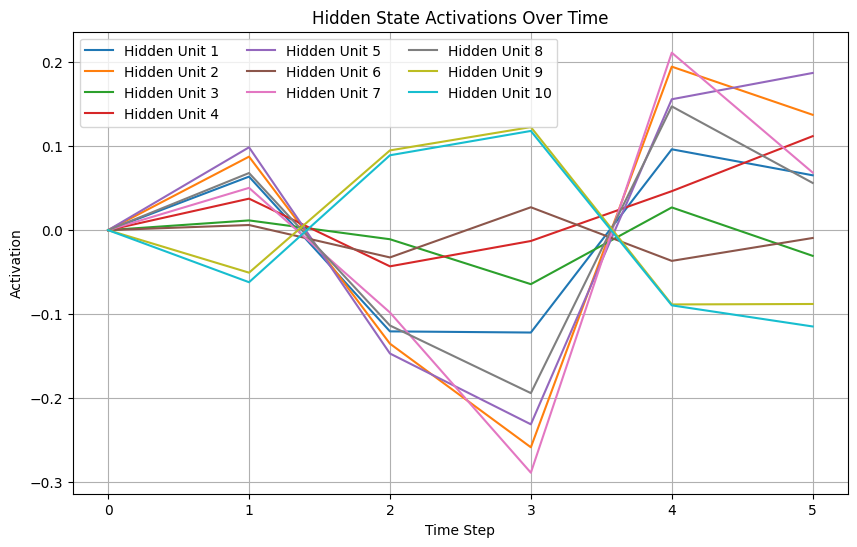

In [29]:
if __name__ == "__main__":
    # --- Compare Training with and without Dropout ---
    num_epochs_dropout = 50
    dropout_rate_no = 0.0
    dropout_rate_yes = 0.5
    training_data_dropout = [
        (np.random.randn(3, input_size, 1), [0, 1, 2]),
        (np.random.randn(5, input_size, 1), [1, 2, 0, 1, 2]),
        (np.random.randn(2, input_size, 1), [2, 0]),
        (np.random.randn(4, input_size, 1), [0, 0, 1, 1]),
        (np.random.randn(6, input_size, 1), [1, 0, 2, 1, 0, 2]),
    ]

    print("--- Training without Dropout ---")
    U_no_dropout = np.copy(U)
    W_no_dropout = np.copy(W)
    V_no_dropout = np.copy(V)
    b_no_dropout = np.copy(b)
    c_no_dropout = np.copy(c)
    losses_no_dropout = []
    for epoch in range(num_epochs_dropout):
        total_loss = 0
        for inputs, targets in training_data_dropout:
            U_no_dropout, W_no_dropout, V_no_dropout, b_no_dropout, c_no_dropout, loss = \
                train_step(list(inputs), targets, U_no_dropout, W_no_dropout, V_no_dropout, b_no_dropout, c_no_dropout, learning_rate)
            total_loss += loss
        avg_loss = total_loss / len(training_data_dropout)
        losses_no_dropout.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs_dropout}, Average Loss: {avg_loss:.4f}")

    print("\n--- Training with Dropout (rate = 0.5) ---")
    U_dropout = np.copy(U)
    W_dropout = np.copy(W)
    V_dropout = np.copy(V)
    b_dropout = np.copy(b)
    c_dropout = np.copy(c)
    losses_dropout = []
    for epoch in range(num_epochs_dropout):
        total_loss = 0
        for inputs, targets in training_data_dropout:
            outputs, hidden_states, dropout_masks = forward_with_dropout(list(inputs), U_dropout, W_dropout, V_dropout, b_dropout, c_dropout, dropout_rate_yes)
            dU, dW, dV, db, dc = backward_with_dropout(list(inputs), outputs, hidden_states, targets, U_dropout, W_dropout, V_dropout, b_dropout, c_dropout, dropout_masks)
            U_dropout -= learning_rate * dU
            W_dropout -= learning_rate * dW
            V_dropout -= learning_rate * dV
            b_dropout -= learning_rate * db
            c_dropout -= learning_rate * dc
            loss = -np.mean([np.log(outputs[t][targets[t], 0] + 1e-8) for t in range(len(targets))])
            total_loss += loss
        avg_loss = total_loss / len(training_data_dropout)
        losses_dropout.append(avg_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs_dropout}, Average Loss: {avg_loss:.4f}")

    plt.figure()
    plt.plot(losses_no_dropout, label='No Dropout')
    plt.plot(losses_dropout, label=f'Dropout (rate={dropout_rate_yes})')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Comparison of Training Loss with and without Dropout')
    plt.legend()
    plt.show()

    # --- Train with Different Batch Sizes ---
    num_epochs_batch = 30
    batch_sizes = [1, 2, 4]
    training_data_batch_raw = [
        (np.random.randn(3, input_size, 1), [0, 1, 2]),
        (np.random.randn(3, input_size, 1), [1, 2, 0]),
        (np.random.randn(4, input_size, 1), [2, 0, 1, 2]),
        (np.random.randn(4, input_size, 1), [0, 1, 1, 0]),
        (np.random.randn(3, input_size, 1), [1, 0, 2]),
        (np.random.randn(4, input_size, 1), [0, 2, 1, 0]),
    ]

    plt.figure()
    for batch_size in batch_sizes:
        print(f"\n--- Training with Batch Size: {batch_size} ---")
        U_batch = np.copy(U)
        W_batch = np.copy(W)
        V_batch = np.copy(V)
        b_batch = np.copy(b)
        c_batch = np.copy(c)
        losses_batch = []
        batched_data = []
        temp_batch_inputs = []
        temp_batch_targets = []
        for inputs, targets in training_data_batch_raw:
            if len(temp_batch_inputs) < batch_size:
                temp_batch_inputs.append(inputs)
                temp_batch_targets.append(targets)
            if len(temp_batch_inputs) == batch_size:
                batched_data.append((temp_batch_inputs, temp_batch_targets))
                temp_batch_inputs = []
                temp_batch_targets = []
        if temp_batch_inputs:
            batched_data.append((temp_batch_inputs, temp_batch_targets))

        for epoch in range(num_epochs_batch):
            total_loss = 0
            for batch_inputs, batch_targets in batched_data:
                U_batch, W_batch, V_batch, b_batch, c_batch, loss = \
                    train_step_batch(batch_inputs, batch_targets, U_batch, W_batch, V_batch, b_batch, c_batch, learning_rate)
                total_loss += loss
            avg_loss = total_loss / len(batched_data)
            losses_batch.append(avg_loss)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs_batch}, Average Loss: {avg_loss:.4f}")
        plt.plot(losses_batch, label=f'Batch Size: {batch_size}')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Comparison of Training Loss with Different Batch Sizes')
    plt.legend()
    plt.show()

    # --- Pretraining and Fine-tuning ---
    print("\n--- Pretraining the RNN ---")
    num_epochs_pretrain = 30
    learning_rate_pretrain = 0.01
    U_pretrained = np.copy(U)
    W_pretrained = np.copy(W)
    V_pretrained = np.copy(V)
    b_pretrained = np.copy(b)
    c_pretrained = np.copy(c)
    pretrained_data = [
        (np.random.randn(5, input_size, 1), [0, 1, 2, 0, 1]),
        (np.random.randn(4, input_size, 1), [1, 2, 0, 2]),
        (np.random.randn(6, input_size, 1), [2, 0, 1, 2, 0, 1]),
        (np.random.randn(3, input_size, 1), [0, 1, 0]),
        (np.random.randn(7, input_size, 1), [1, 2, 1, 0, 2, 1, 0]),
    ]
    for epoch in range(num_epochs_pretrain):
        total_loss = 0
        for inputs, targets in pretrained_data:
            U_pretrained, W_pretrained, V_pretrained, b_pretrained, c_pretrained, loss = \
                train_step(list(inputs), targets, U_pretrained, W_pretrained, V_pretrained, b_pretrained, c_pretrained, learning_rate_pretrain)
            total_loss += loss
        avg_loss = total_loss / len(pretrained_data)
        if (epoch + 1) % 10 == 0:
            print(f"Pretrain Epoch {epoch + 1}/{num_epochs_pretrain}, Average Loss: {avg_loss:.4f}")
    save_model(U_pretrained, W_pretrained, V_pretrained, b_pretrained, c_pretrained)

    print("\n--- Fine-tuning the Pretrained RNN ---")
    learning_rate_finetune = 0.001
    U_finetuned, W_finetuned, V_finetuned, b_finetuned, c_finetuned = load_model()
    if U_finetuned is not None:
        custom_dataset = [
            (np.random.randn(3, input_size, 1), [0, 2, 1]),
            (np.random.randn(2, input_size, 1), [1, 0]),
        ]
        num_epochs_finetune = 20
        for epoch in range(num_epochs_finetune):
            total_loss = 0
            for inputs, targets in custom_dataset:
                U_finetuned, W_finetuned, V_finetuned, b_finetuned, c_finetuned, loss = \
                    train_step(list(inputs), targets, U_finetuned, W_finetuned, V_finetuned, b_finetuned, c_finetuned, learning_rate_finetune)
                total_loss += loss
            avg_loss = total_loss / len(custom_dataset)
            if (epoch + 1) % 10 == 0:
                print(f"Finetune Epoch {epoch + 1}/{num_epochs_finetune}, Average Loss: {avg_loss:.4f}")

        # --- Visualize Hidden States (using fine-tuned model) ---
        U_vis = U_finetuned if U_finetuned is not None else U
        W_vis = W_finetuned if W_finetuned is not None else W
        V_vis = V_finetuned if V_finetuned is not None else V
        b_vis = b_finetuned if b_finetuned is not None else b
        c_vis = c_finetuned if c_finetuned is not None else c
        example_input = list(np.random.randn(5, input_size, 1))
        visualize_hidden_states(example_input, U_vis, W_vis, V_vis, b_vis, c_vis)